In [1]:
import numpy as np 
import pandas as pd 

import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import re
import string
from string import digits

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize

import matplotlib.pyplot as plt
import os

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pd.read_excel("/kaggle/input/sanskrit2/dict.xlsx")
df.head(10)

,English,Sanskrit
0,I,अहम्
1,me,माम्
2,you,त्वम्
3,go,गच्छ
4,went,अगच्छत्
5,he,सः
6,she,सा
7,it,तत्
8,we,वयम्
9,they,ते


In [3]:
df.head(10)

,English,Sanskrit
0,I,अहम्
1,me,माम्
2,you,त्वम्
3,go,गच्छ
4,went,अगच्छत्
5,he,सः
6,she,सा
7,it,तत्
8,we,वयम्
9,they,ते


In [4]:
df.drop_duplicates(inplace=True)

In [5]:
df.shape

(1382, 2)

# Data Preprocessing

In [6]:
# Lowercase all characters
df['English']=df['English'].apply(lambda x: x.lower())
df['Sanskrit']=df['Sanskrit'].apply(lambda x: x.lower())

In [7]:
# Remove quotes
df['English']=df['English'].apply(lambda x: re.sub("'", '', x))
df['Sanskrit']=df['Sanskrit'].apply(lambda x: re.sub("'", '', x))

In [8]:
exclude = set(string.punctuation) # Set of all special characters
# Remove all the special characters
df['English']=df['English'].apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
df['Sanskrit']=df['Sanskrit'].apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

In [9]:
# Remove all numbers from text
remove_digits = str.maketrans('', '', digits)
df['English']=df['English'].apply(lambda x: x.translate(remove_digits))
df['Sanskrit']=df['Sanskrit'].apply(lambda x: x.translate(remove_digits))
df['Sanskrit'] = df['Sanskrit'].apply(lambda x: re.sub("[२३०८१५७९४६]", "", x))

In [10]:
# Remove extra spaces
df['English']=df['English'].apply(lambda x: x.strip())
df['Sanskrit']=df['Sanskrit'].apply(lambda x: x.strip())
df['English']=df['English'].apply(lambda x: re.sub(" +", " ", x))
df['Sanskrit']=df['Sanskrit'].apply(lambda x: re.sub(" +", " ", x))

In [11]:

df['Sanskrit']=df['Sanskrit'].apply(lambda x: re.sub("[a-zA-Z]", " ", x))

In [12]:
df.head()

,English,Sanskrit
0,i,अहम्
1,me,माम्
2,you,त्वम्
3,go,गच्छ
4,went,अगच्छत्


In [12]:
stop_words = stopwords.words('english') 

In [13]:
corpus = ' '
for line in df['English']:
    corpus += ' '.join(line.split())
# corpus

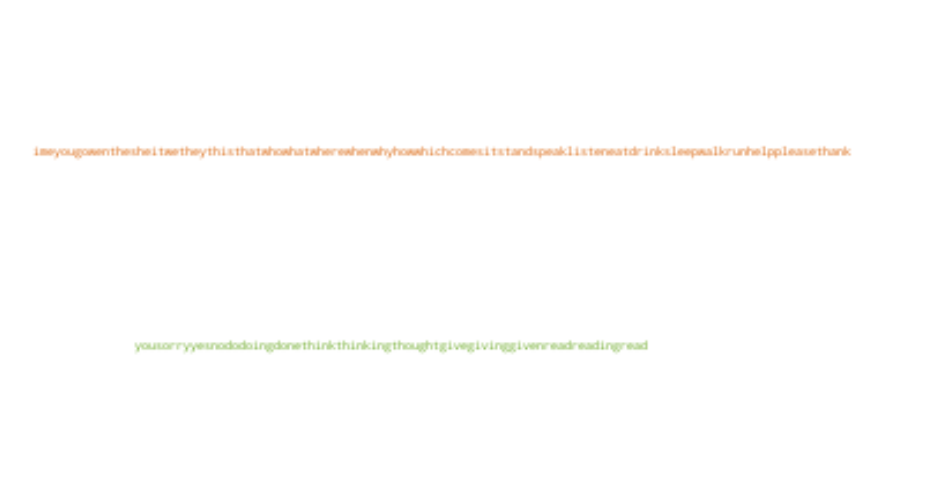

In [14]:
from wordcloud import WordCloud

wc = WordCloud(stopwords=stop_words, background_color="white", colormap="Dark2",
               max_font_size=150 )

wc.generate(corpus)

plt.rcParams["figure.figsize"] = (16,6)
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
    
plt.show()


In [15]:
# Vectorize the data

input_texts = []
target_texts = []

input_characters = set()
target_characters = set()

In [16]:
for line in df['English']:
    input_texts.append(line)
    for char in line:
        if re.findall("[a-zA-Z]", char) or char == ' ':
            if char not in input_characters:
                input_characters.add(char)
            
for line in df['Sanskrit']:
    
    target_text = '%' + line + '$'
    
    target_texts.append(line)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

In [17]:
target_characters

{' ',
 '$',
 '%',
 'ँ',
 'ं',
 'ः',
 'अ',
 'आ',
 'इ',
 'ई',
 'उ',
 'ऊ',
 'ऋ',
 'ए',
 'ऐ',
 'ऑ',
 'ओ',
 'औ',
 'क',
 'ख',
 'ग',
 'घ',
 'ङ',
 'च',
 'छ',
 'ज',
 'झ',
 'ञ',
 'ट',
 'ठ',
 'ड',
 'ढ',
 'ण',
 'त',
 'थ',
 'द',
 'ध',
 'न',
 'प',
 'फ',
 'ब',
 'भ',
 'म',
 'य',
 'र',
 'ल',
 'व',
 'श',
 'ष',
 'स',
 'ह',
 '़',
 'ा',
 'ि',
 'ी',
 'ु',
 'ू',
 'ृ',
 'े',
 'ै',
 'ॉ',
 'ो',
 'ौ',
 '्'}

In [18]:
# from nltk import ngrams 
# list(ngrams(words,2))

In [19]:
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))

num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)

max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

In [20]:
print("Number of samples : ", len(input_texts))
print("Number of unique input tokens : ", num_encoder_tokens)
print("Number of unique output tokens : ", num_decoder_tokens)
print("Max sequence length for inputs : ", max_encoder_seq_length)
print("Max sequence length for outputs : ", max_decoder_seq_length)

Number of samples :  1382
Number of unique input tokens :  27
Number of unique output tokens :  64
Max sequence length for inputs :  23
Max sequence length for outputs :  24


In [21]:
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

In [22]:
#input_token_index

# Encoder and Decoder Architecture

In [23]:
encoder_input_data = np.zeros((len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype='float32')
decoder_input_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype='float32')
decoder_target_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype='float32')

In [24]:
print("Encoder input data : ", encoder_input_data.shape)
print("Decoder input data : ", decoder_input_data.shape)
print("Decoder target data : ", decoder_target_data.shape)

Encoder input data :  (1382, 23, 27)
Decoder input data :  (1382, 24, 64)
Decoder target data :  (1382, 24, 64)


# Coverting text into one hot encoding 

In [25]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        if re.findall("[a-zA-Z]", char) or char == ' ': 
            encoder_input_data[i,t, input_token_index[char]] = 1
    encoder_input_data[i,t+1:, input_token_index[' ']] = 1
    
    for t, char in enumerate(target_text):
        decoder_input_data[i, t, target_token_index[char]] = 1
        
        if t > 0:
            decoder_target_data[i, t-1, target_token_index[char]] = 1
            
    decoder_input_data[i,t+1:, target_token_index[' ']] = 1
    decoder_target_data[i, t:, target_token_index[' ']] = 1

In [26]:
encoder_input_data[0]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],


In [27]:
batch_size = 128 # Batch size for training
epochs = 100 # Number of epochs to train for
latent_dim = 256

# Encoder LSTM model

In [28]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Decoder LSTM Model

In [29]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the 
# return states in the training model, but we will use them in inference.

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)

decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [30]:
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [31]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 27)]   0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None, 64)]   0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 256),        290816      ['input_1[0][0]']                
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                              

In [32]:
checkpoint_path = "/kaggle/working/training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [33]:
history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2,
         callbacks=[cp_callback])

Epoch 1/100
9/9 [==============================] - ETA: 0s - loss: 2.1231 - accuracy: 0.6701
Epoch 1: saving model to /kaggle/working/training_1/cp.ckpt
9/9 [==============================] - 8s 401ms/step - loss: 2.1231 - accuracy: 0.6701 - val_loss: 1.0136 - val_accuracy: 0.7653
Epoch 2/100
9/9 [==============================] - ETA: 0s - loss: 1.0285 - accuracy: 0.7684
Epoch 2: saving model to /kaggle/working/training_1/cp.ckpt
9/9 [==============================] - 2s 254ms/step - loss: 1.0285 - accuracy: 0.7684 - val_loss: 0.9627 - val_accuracy: 0.7795
Epoch 3/100
9/9 [==============================] - ETA: 0s - loss: 0.9832 - accuracy: 0.7728
Epoch 3: saving model to /kaggle/working/training_1/cp.ckpt
9/9 [==============================] - 2s 248ms/step - loss: 0.9832 - accuracy: 0.7728 - val_loss: 0.9927 - val_accuracy: 0.7759
Epoch 4/100
9/9 [==============================] - ETA: 0s - loss: 0.9722 - accuracy: 0.7723
Epoch 4: saving model to /kaggle/working/training_1/cp.ckpt
9

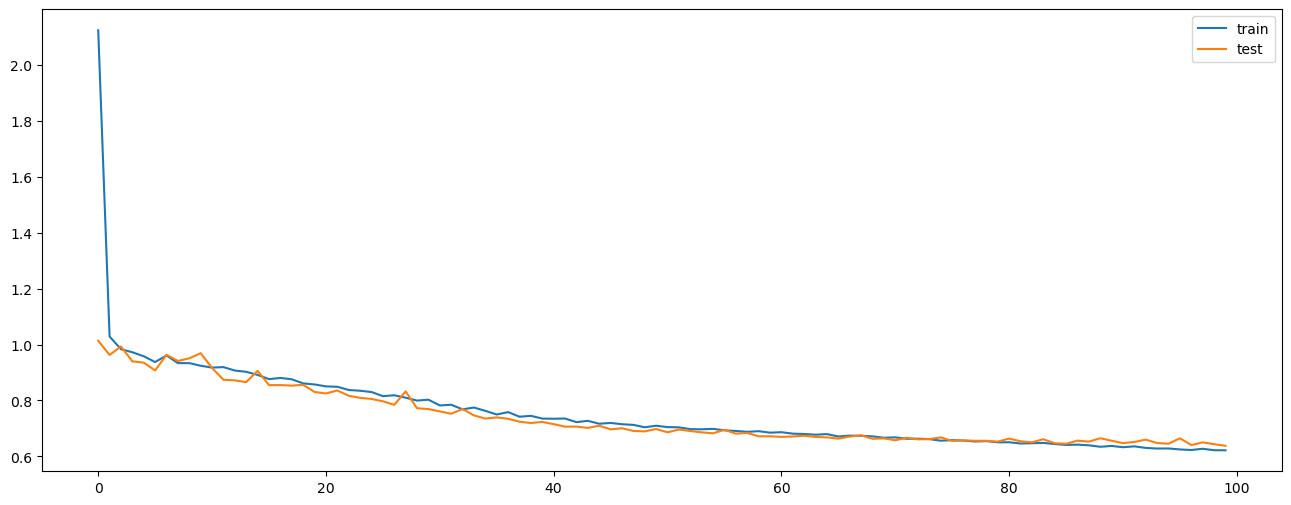

In [34]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

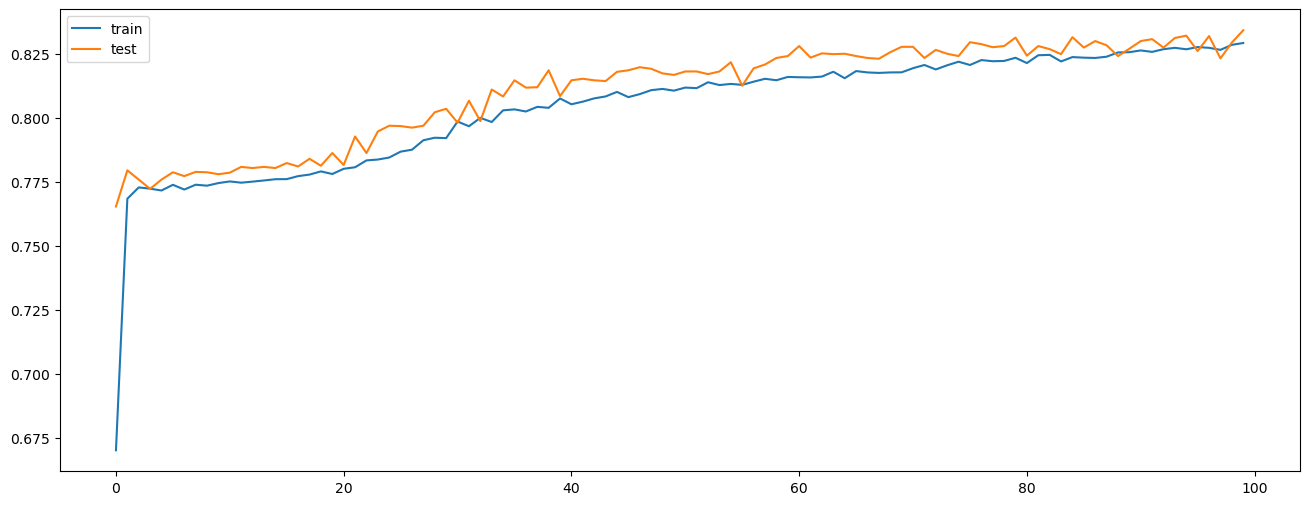

In [35]:
from matplotlib import pyplot
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

In [36]:
# # Loads the weights
# model.load_weights('/kaggle/working/training_1/cp.ckpt')

In [37]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))

decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state = decoder_states_inputs)

decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

In [38]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['%']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    
    stop_condition = False
    
    decoded_sentence = ''
    
    while not stop_condition:
        
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        print(sampled_token_index)
        sampled_char = reverse_target_char_index[sampled_token_index]
        print(sampled_char)
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        
        if (sampled_char == '$' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [39]:
for seq_index in range(5):
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence : ', input_texts[seq_index])
    print('Decoded sentence : ', decoded_sentence)

1/1 [==============================] - 0s 476ms/step
53
ि
1/1 [==============================] - 0s 28ms/step
18
क
1/1 [==============================] - 0s 27ms/step
63
्
1/1 [==============================] - 0s 26ms/step
48
ष
1/1 [==============================] - 0s 27ms/step
42
म
1/1 [==============================] - 0s 26ms/step
63
्
1/1 [==============================] - 0s 31ms/step
0
 
1/1 [==============================] - 0s 27ms/step
0
 
1/1 [==============================] - 0s 30ms/step
0
 
1/1 [==============================] - 0s 27ms/step
0
 
1/1 [==============================] - 0s 33ms/step
0
 
1/1 [==============================] - 0s 28ms/step
0
 
1/1 [==============================] - 0s 28ms/step
0
 
1/1 [==============================] - 0s 29ms/step
0
 
1/1 [==============================] - 0s 30ms/step
0
 
1/1 [==============================] - 0s 29ms/step
0
 
1/1 [==============================] - 0s 29ms/step
0
 
1/1 [==============================] - 0s

In [40]:
decoder_input_data[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [41]:
decoder_input_data[1]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [42]:
decoder_input_data[0] == decoder_input_data[1]

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [43]:
np.unique(decoder_input_data[2] == decoder_input_data[4],return_counts=True)

(array([False,  True]), array([  14, 1522]))

In [44]:
np.allclose(decoder_input_data[2], decoder_input_data[4])

False